In [ ]:
# 1. Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# 2. Install dependencies
%pip install -r /content/drive/MyDrive/ddpm_pytorch/requirements.txt

import os, sys
drive_path = "/content/drive/MyDrive/ddpm_pytorch"
if os.path.exists(drive_path):
    os.chdir(drive_path)
    print("Changed dir:", os.getcwd())
else:
    raise FileNotFoundError(f"{drive_path} not found")

sys.path.append(os.getcwd())
print("Added to sys.path:", os.getcwd())

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

torch.backends.cudnn.benchmark = True

Using device: cuda


In [3]:
# ---------------------------------
# Data using CIFAR10
# ---------------------------------
import os
from tqdm.auto import tqdm
import torch

from models.unet import UNet
from diffusion.gaussian_diffusion import GaussianDiffusion
from ema_pytorch import EMA

from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

image_size = 32
batch_size = 128
num_workers = 2
pin_memory = True

transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

train_ds = CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=pin_memory,
)

test_ds = CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

print("Train:", len(train_ds))
print("Test:", len(test_ds))

Files already downloaded and verified
Files already downloaded and verified
Train: 50000
Test: 10000


In [4]:
# ---------------------------------
# Model / Diffusion / Optimizer
# ---------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dim=128,
    dim_mults=(1, 2, 4, 8),
    image_size=image_size,
    dropout=0.1,
    channels=3,
).to(device)

diffusion = GaussianDiffusion(
    model=model,
    image_size=image_size,
    channels=3,
    timesteps=1000,
    beta_start=1e-4,
    beta_end=0.02,
).to(device)

optimizer = torch.optim.Adam(diffusion.parameters(), lr=2e-4, betas=(0.9, 0.999))

ema = EMA(
    diffusion,
    beta=0.9999,
    update_after_step=0,
    update_every=1,
).to(device)

is_cuda = device.type == "cuda"
scaler = torch.amp.GradScaler(device.type, enabled=is_cuda)

In [ ]:
# ---------------------------------
# Training loop
# ---------------------------------
import math

target_steps = 10000 #lower it based on your storage, but originally 80k
grad_accum = 2

steps_per_epoch = len(train_dl) // grad_accum
epochs = math.ceil(target_steps / max(1, steps_per_epoch))

save_dir = "./results"
os.makedirs(save_dir, exist_ok=True)

global_step = 0
diffusion.train()
model.train()

for epoch in range(epochs):
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}", leave=False)
    avg_loss = 0.0

    for i, batch in enumerate(pbar):
        imgs, _ = batch
        imgs = imgs.to(device, non_blocking=True)

        with torch.autocast(device_type=device.type, enabled=is_cuda):
            loss = diffusion(imgs) / grad_accum

        scaler.scale(loss).backward()

        if (i + 1) % grad_accum == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

            ema.update()
            global_step += 1

        loss_item = loss.item() * grad_accum
        avg_loss = loss_item if avg_loss == 0.0 else 0.9 * avg_loss + 0.1 * loss_item
        pbar.set_postfix(loss=f"{avg_loss:.4f}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")

    ckpt_path = os.path.join(save_dir, f"model_epoch_{epoch}.pt")
    torch.save(
        {
            "model": model.state_dict(),
            "diffusion": diffusion.state_dict(),
            "optimizer": optimizer.state_dict(),
            "ema": ema.state_dict(),
            "epoch": epoch,
            "global_step": global_step,
        },
        ckpt_path,
    )
    print(f"Saved {ckpt_path} | avg_loss {avg_loss:.4f}")

In [15]:
print(f"Saved {ckpt_path} | avg_loss {avg_loss:.4f}")

Saved ./results/model_epoch_37.pt | avg_loss 0.0319


In [ ]:
import torch
from ema_pytorch import EMA
from train.evaluation import FIDEvaluation

# Load checkpoint (add weights_only=True once you’ve moved to PyTorch ≥2.4)
ckpt_path = "./results/model_epoch_37.pt"
print(f"Loading checkpoint: {ckpt_path}")
ckpt = torch.load(ckpt_path, map_location=device)

model.load_state_dict(ckpt["model"])
diffusion.load_state_dict(ckpt["diffusion"])

ema = EMA(
    diffusion,
    beta=0.9999,
    update_after_step=0,
    update_every=1,
).to(device)
if "ema" in ckpt:
    ema.load_state_dict(ckpt["ema"])

diffusion.eval()
ema.ema_model.eval()

# Image-only wrapper so FID sees tensors, not (img,label) tuples
class ImageOnlyLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for imgs, _ in self.dataloader:
            yield imgs
    def __len__(self):
        return len(self.dataloader)

real_dl = ImageOnlyLoader(test_dl)

class DiffusionSamplerWrapper:
    def __init__(self, diffusion, device):
        self.diffusion = diffusion
        self.device = device

    def eval(self):
        self.diffusion.eval()

    @torch.inference_mode()
    def sample(self, batch_size):
        samples = self.diffusion.sample(batch_size=batch_size)
        return samples.to(self.device)

sampler = DiffusionSamplerWrapper(diffusion=ema.ema_model, device=device)

fid_eval = FIDEvaluation(
    batch_size=256,
    dataloader=real_dl,
    sampler=sampler,
    device=device,
    channels=3,
    num_samples=10_000,  # Ideally set it to 50k with enough time and computing power
)

print("Computing FID…")
fid_value = fid_eval.fid_score()
print(f"FID: {fid_value:.4f}")


In [7]:
print(f"FID: {fid_value:.4f}")

FID: 39.2821


In [8]:
import torch
from torchvision.utils import make_grid, save_image

batch_size = 10
num_steps_to_show = 10

with torch.no_grad():
    traj = diffusion.sample(batch_size=batch_size, return_all_timesteps=True)
assert traj.dim() == 5, f"Expected (T,B,C,H,W), got {traj.shape}"

if traj.size(0) < traj.size(1):
    traj = traj.permute(1, 0, 2, 3, 4).contiguous()

T = traj.size(0)
idx = torch.linspace(0, T - 1, steps=num_steps_to_show, device=traj.device).round().long()
idx = torch.unique_consecutive(idx)
traj = traj.index_select(0, idx)
k = traj.size(0)

traj = (traj + 1) / 2
traj = traj.clamp(0, 1)

_, B, C, H, W = traj.shape
flat = traj.permute(1, 0, 2, 3, 4).contiguous().view(B * k, C, H, W)
grid = make_grid(flat, nrow=k, padding=2)

save_image(grid.cpu(), f'generated.png')
print(f"Saved panel with {B} rows × {k} columns (10×10).")


sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved panel with 10 rows × 10 columns (10×10).


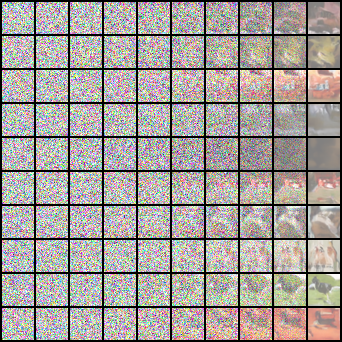

In [9]:
from IPython.display import Image
generated_png = "/content/drive/MyDrive/ddpm_pytorch/generated.png"
Image(generated_png, width=800)

In [16]:
from IPython.display import display, clear_output
clear_output(wait=False)
